#MLB Per-Season Home Run Projections

##Intro

The main aim of this work will be to project a players total number of home runs in a season based entirely on all of their hitting stats from the season prior.

My plan is to use fit a regression model to the data I have (on hitters spanning 152 years of baseball), and test it's output against this same data. I expect a main speed bump to be accounting for injuries or other variables that impact games played, but the sheer size of the dataframe should help account for this. I wonder if I can set a number of games as opposed to a season (year) to base my output on, which would also allow for increased usage, but possibly lead to less accurate projections if the number of games used is low.

Credit:
The data used in this notebook comes from Sean Lahmans 'Lahman Baseball Database.' The database is licenced under a 'CC BY-SA 3.0' licence, which allows full use of the data, provided that proper credit and future licensing requirements are held. For details see: http://creativecommons.org/licenses/by-sa/3.0/

In [ ]:
#imports

#%pip install pandas
#%pip install numpy
#%pip install matplotlib
#%pip install seaborn
#%pip install scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

Relative to last progress update on the final, the biggest change has been in my data set. I found an extremely large raw baseball data library, which will help me fit a stronger model than I otherwise would have been able to. This will likely require more data cleaning and fitting for my specific goals, which will be a better learning experience as well. It was already somewhat of a challenge downloading and opening the data on mac with a .7z file type. I used an app called 'The Unarchiver' to extract the files.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cs356/baseball/Batting.csv')
print(df.shape) #wow
df.describe().round(2)

(113799, 24)


,yearID,stint,G,G_batting,AB,R,H,2B,3B,HR,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,G_old
count,113799.00,113799.00,113799.00,1615.00,113799.00,113799.00,113799.00,113799.00,113799.00,113799.00,...,111431.00,90257.00,113799.00,111699.00,77148.00,110983.00,107731.00,77695.00,88357.00,0.0
mean,1969.63,1.08,50.38,31.42,137.42,18.24,35.84,6.14,1.21,2.87,...,2.86,1.14,12.69,20.75,1.01,1.07,2.11,1.00,2.84,NaN
std,40.45,0.29,46.74,48.66,182.99,27.89,51.87,9.60,2.55,6.41,...,7.51,2.63,20.48,29.20,2.65,2.32,4.08,1.91,4.64,NaN
min,1871.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN
25%,1939.00,1.00,12.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,NaN
50%,1979.00,1.00,34.00,1.00,44.00,4.00,8.00,1.00,0.00,0.00,...,0.00,0.00,2.00,8.00,0.00,0.00,0.00,0.00,0.00,NaN
75%,2004.00,1.00,78.00,49.50,220.00,26.00,54.00,9.00,1.00,2.00,...,2.00,1.00,17.00,29.00,1.00,1.00,3.00,1.00,4.00,NaN
max,2023.00,5.00,165.00,162.00,716.00,198.00,262.00,67.00,36.00,73.00,...,138.00,42.00,232.00,223.00,120.00,51.00,67.00,19.00,36.00,NaN


##Setting up the Data

In [ ]:
# First, getting rid of unnecessary columns
# We don't need player/team/time identifiers (yet), as we want to look only at the underlying numbers
gamesbatting = df['G_batting']
print(gamesbatting.isnull().sum())

gold = df['G_old']
print(gold.isnull().sum())
# G_batting and G_old are also dropped, as over 98% of values are empty for each

# initial model df
m_df_init = df.drop(columns=['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G_batting', 'G_old'])
m_df_init.describe().round(2)

112184
113799


,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
count,113799.00,113799.00,113799.00,113799.00,113799.00,113799.00,113799.00,113043.00,111431.00,90257.00,113799.00,111699.00,77148.00,110983.00,107731.00,77695.00,88357.00
mean,50.38,137.42,18.24,35.84,6.14,1.21,2.87,16.60,2.86,1.14,12.69,20.75,1.01,1.07,2.11,1.00,2.84
std,46.74,182.99,27.89,51.87,9.60,2.55,6.41,26.12,7.51,2.63,20.48,29.20,2.65,2.32,4.08,1.91,4.64
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,12.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
50%,34.00,44.00,4.00,8.00,1.00,0.00,0.00,3.00,0.00,0.00,2.00,8.00,0.00,0.00,0.00,0.00,0.00
75%,78.00,220.00,26.00,54.00,9.00,1.00,2.00,24.00,2.00,1.00,17.00,29.00,1.00,1.00,3.00,1.00,4.00
max,165.00,716.00,198.00,262.00,67.00,36.00,73.00,191.00,138.00,42.00,232.00,223.00,120.00,51.00,67.00,19.00,36.00


Before delving too far into the data, for the purpose of interpretability, I've created the following dictionary for referencing the meaning of each column

In [ ]:
features = {
    'yearID': 'Year',
    'playerID': 'Player',
    'G': 'Games',
    'AB': 'At Bats',
    'R': 'Runs',
    'H': 'Hits',
    '2B': 'Doubles',
    '3B': 'Triples',
    'HR': 'Homeruns',
    'RBI': 'Runs Batted In',
    'SB': 'Stolen Bases',
    'CS': 'Caught Stealing',
    'BB': 'Base on Balls',
    'SO': 'Strikeouts',
    'IBB': 'Intentional walks',
    'HBP': 'Hit by pitch',
    'SH': 'Sacrifice hits',
    'SF': 'Sacrifice flies',
    'GIDP': 'Grounded into double plays'
}

In [ ]:
# Still a lot of imputation to be done
m_df_init.isnull().sum()

,0
G,0
AB,0
R,0
H,0
2B,0
3B,0
HR,0
RBI,756
SB,2368
CS,23542


In [ ]:
targets = ['RBI', 'SB', 'CS', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']
other_features = ['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'BB']
# New df, for imputed values
m_df = m_df_init.copy()

rf_model = RandomForestRegressor()
lr_model = LinearRegression()

# From here, the loop is carried for each feature that's missing values, listed in targets
for target in targets:
    # Splitting the orignal df into empty and filled values
    train_data = m_df[m_df[target].notnull()]
    predict_data = m_df[m_df[target].isnull()]

    # A random forest regressor is used to select the top 3 features for each target
    # Only the top 3 are used, to avoid overfitting as I impute
    rf_model.fit(train_data[other_features], train_data[target])

    feature_importances = rf_model.feature_importances_

    organized_features = np.argsort(feature_importances)[-3:]
    top_3_features = [other_features[i] for i in organized_features]

    if not predict_data.empty:
        # Now, linear regression imputation for missing data
        lr_model.fit(train_data[top_3_features], train_data[target])

        predicted_values = lr_model.predict(predict_data[top_3_features])
        m_df.loc[predict_data.index, target] = predicted_values

This loop took 5m 33s to run, and its relative simplicity makes it feasible even for data of this size, but it's something that could likely be improved on as I work on this project



In [ ]:
print(f'remaining missing values: {m_df.isnull().sum().sum()}\n')
m_df.describe().round(2)

remaining missing values: 0



,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
count,113799.00,113799.00,113799.00,113799.00,113799.00,113799.00,113799.00,113799.00,113799.00,113799.00,113799.00,113799.00,113799.00,113799.00,113799.00,113799.00,113799.00
mean,50.38,137.42,18.24,35.84,6.14,1.21,2.87,16.56,2.93,1.31,12.69,20.66,1.02,1.07,2.21,1.11,3.05
std,46.74,182.99,27.89,51.87,9.60,2.55,6.41,26.06,7.51,2.66,20.48,29.01,2.38,2.30,4.08,1.84,4.55
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.77,-0.06,0.00,0.00,-0.10,0.00,-0.18,-0.03,-0.90
25%,12.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
50%,34.00,44.00,4.00,8.00,1.00,0.00,0.00,3.00,0.00,0.00,2.00,8.00,0.00,0.00,0.00,0.02,1.00
75%,78.00,220.00,26.00,54.00,9.00,1.00,2.00,23.00,2.00,1.17,17.00,29.00,1.00,1.00,3.00,1.70,4.89
max,165.00,716.00,198.00,262.00,67.00,36.00,73.00,191.00,138.00,42.00,232.00,223.00,120.00,51.00,67.00,19.00,36.00


Now, to test the performance of my imputation model, I'll use Kernel Density Estimation (KDE) plots to make a distribution comparison. Because of how large the data is, and how variable the counts are, other methods result in illegible graphs. What I'm looking for in these graphs is mirroring between the original data and imputed data when it comes to the distribution of values across features.

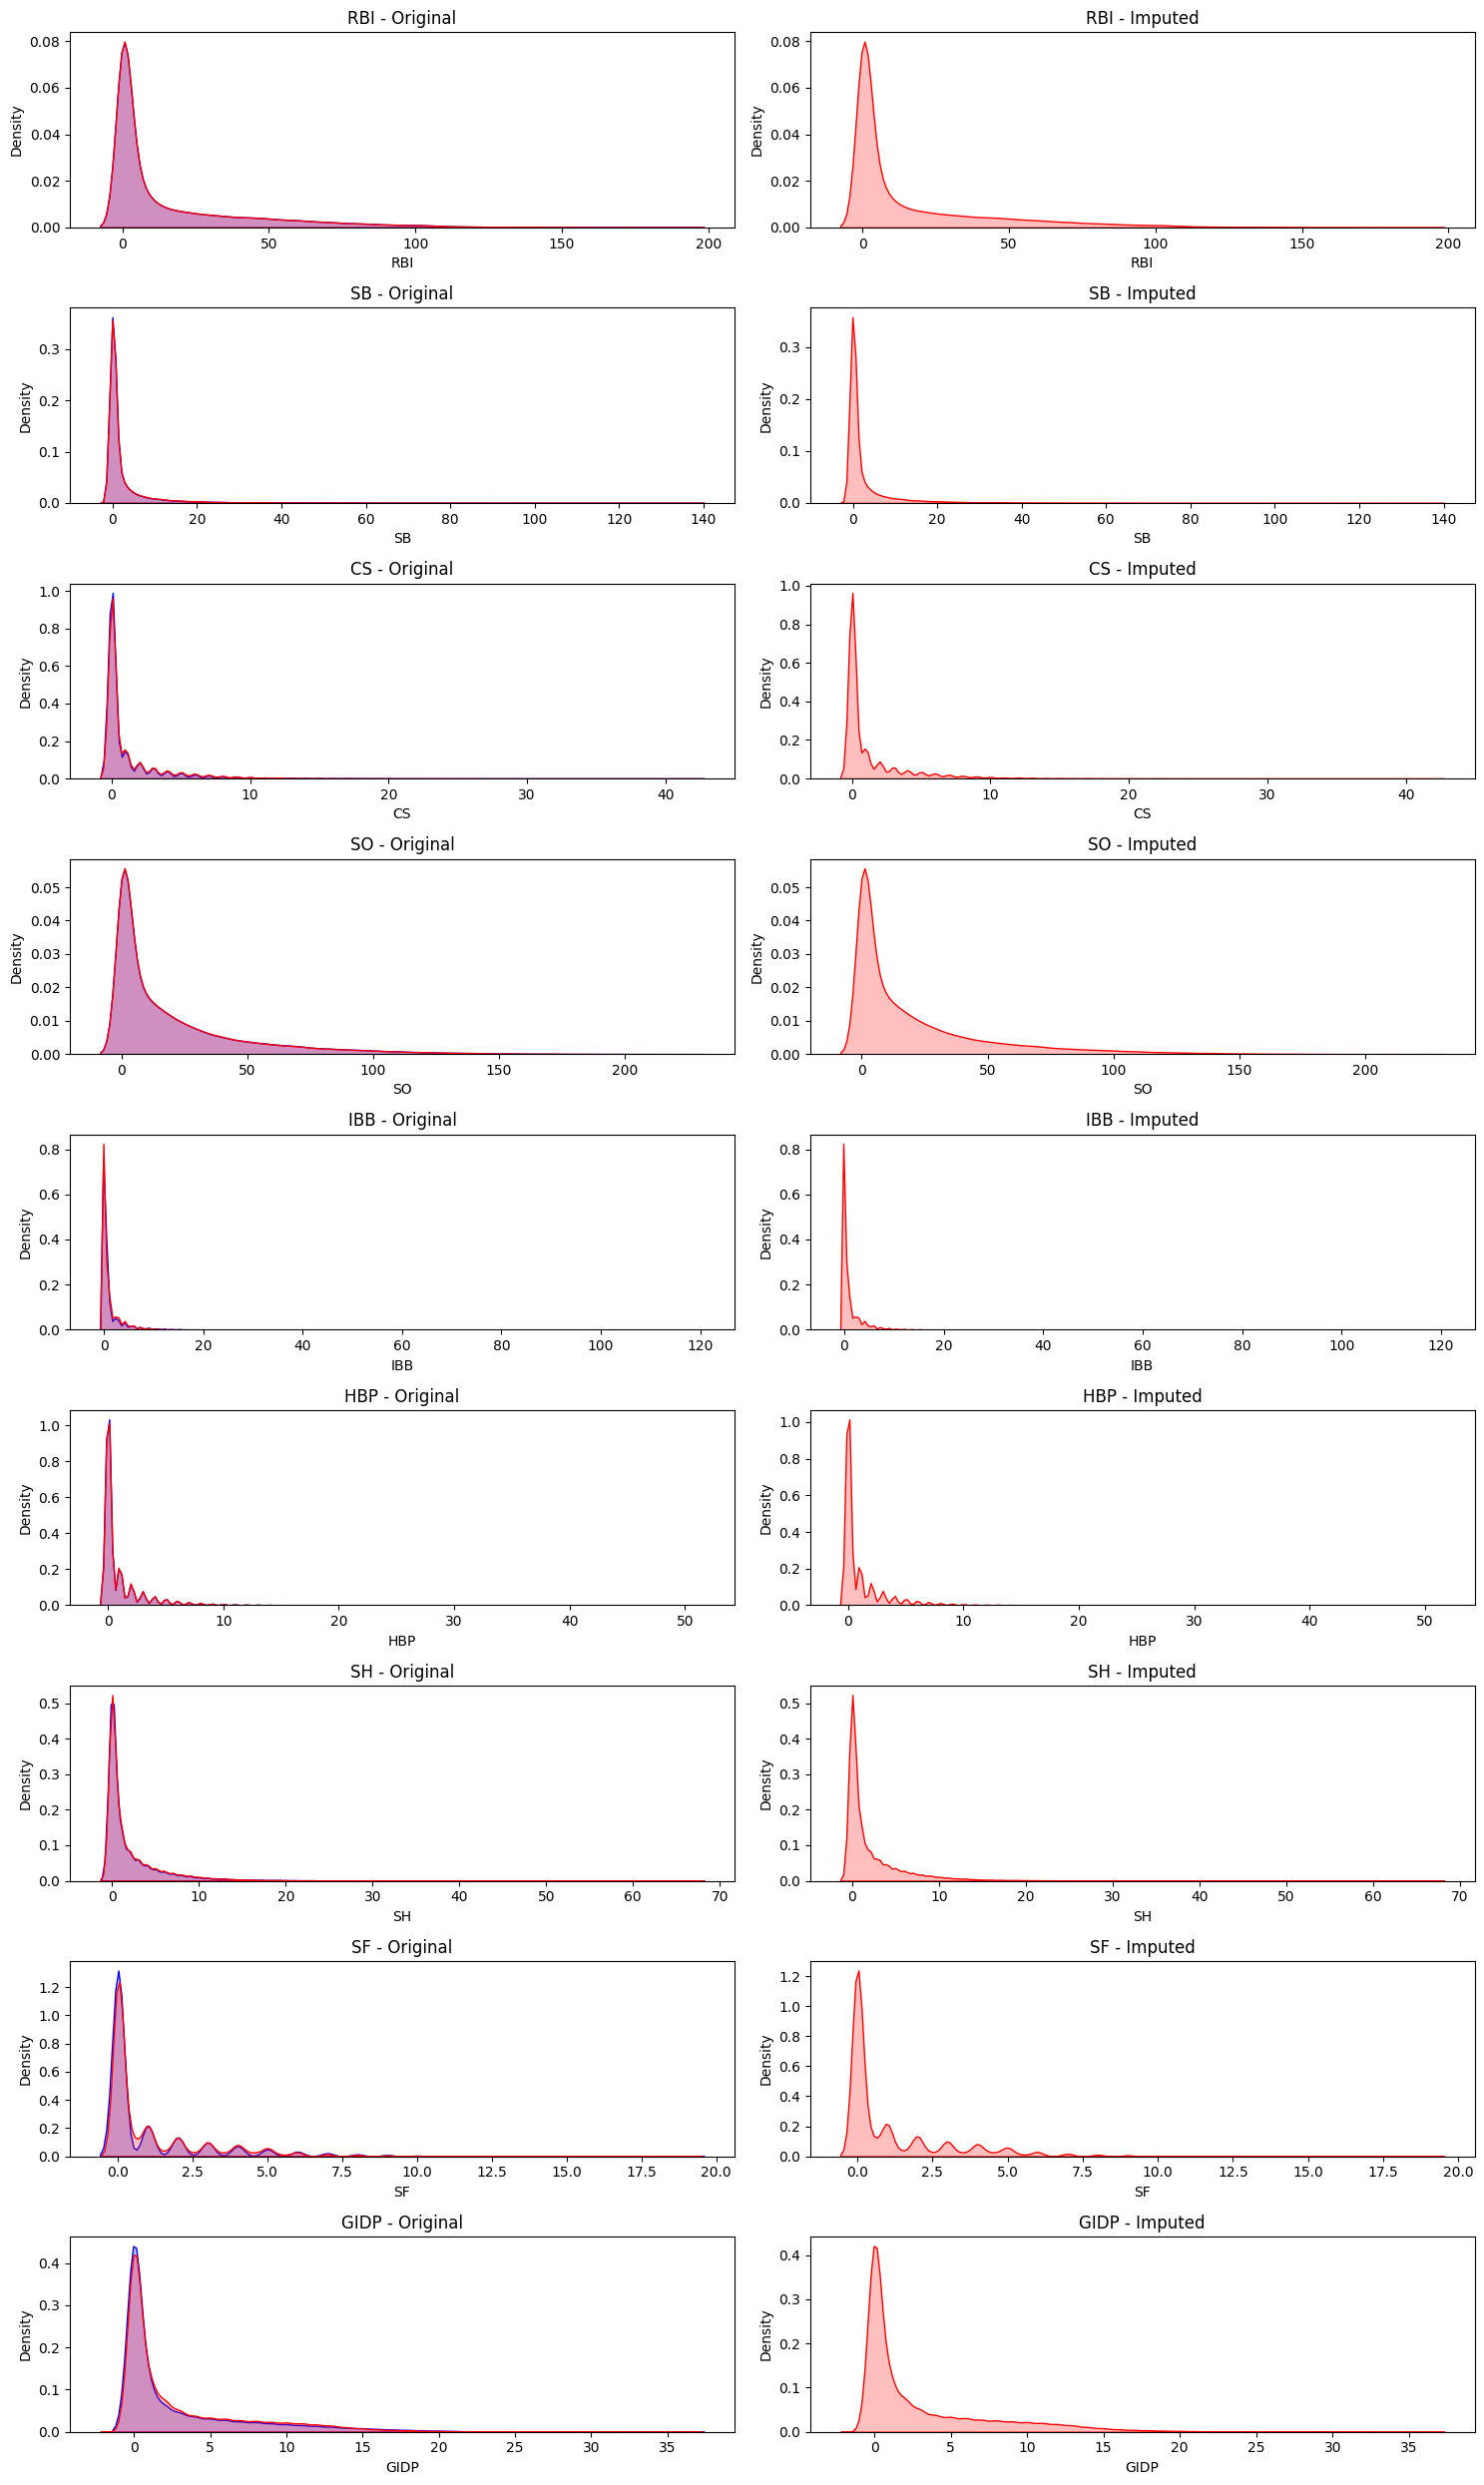

In [ ]:
# KDE plots comparing original data and imputed data

fig, axes = plt.subplots(9, 2, figsize=(15, 25))

for i, target in enumerate(targets):
    sns.kdeplot(m_df_init[target], label='Original', color='blue', fill=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'{target} - Original')

    sns.kdeplot(m_df[target], label='Imputed', color='red', fill=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'{target} - Original')

    sns.kdeplot(m_df[target], label='Imputed', color='red', fill=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'{target} - Imputed')

plt.tight_layout()
plt.show()

Based on the graphs, I can say that my imputation was successful, as the shapes follow very similar structures. I can also verify this by cross referencing my original df's (m_df_init) summary statistics and comparing them to those of my new df (m_df). Per the describe() functions above, the summary statistics look extremely similar, implying again successful imputation. The relationships between variables have been preserved, which will be important for further study of the new df.

##Feature Engineering

In [ ]:
# Time to define and split the target and features
X = m_df.drop(columns=['HR'])
y = m_df['HR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=356)
# We already have a random forest model defined

rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
# Finding feature importances
importances = rf_model.feature_importances_
feature_names = X.columns

feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

print(feature_df)

   Feature  Importance
6      RBI    0.718558
10      SO    0.089792
13      SH    0.082480
11     IBB    0.016616
2        R    0.013379
9       BB    0.010521
3        H    0.010020
4       2B    0.009487
7       SB    0.008214
1       AB    0.007628
14      SF    0.006749
5       3B    0.006491
0        G    0.005773
15    GIDP    0.005414
8       CS    0.005093
12     HBP    0.003785


In [ ]:
# Interesting, and these make some sense in context, lets make some new features and test again
# Starting back from m_df to add features

## These kinda make sense

# Hits per at bat
m_df['H/AB'] = m_df['H'] / m_df['AB']

# Hits per game
m_df['H/G'] = m_df['H'] / m_df['G']

# Strikeouts per at bat
m_df['SO/AB'] = m_df['SO'] / m_df['AB']

# RBI excluding own runs
m_df['RBI-R'] = m_df['RBI'] - m_df['R']

## Playing around a bit more

# Sacrifice hits times intentional walks
m_df['SH*IBB'] = m_df['SH'] * m_df['IBB']

# intentional walks + hit by pitch
m_df['IBB+HBP'] = m_df['IBB'] + m_df['HBP']

# Stolen bases per at bat
m_df['SB/AB'] = m_df['SB'] / m_df['AB']


m_df.describe().round(2)

/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,G,AB,R,H,2B,3B,HR,RBI,SB,CS,...,SH,SF,GIDP,H/AB,H/G,SO/AB,RBI-R,SH*IBB,IBB+HBP,SB/AB
count,113799.00,113799.00,113799.00,113799.00,113799.00,113799.00,113799.00,113799.00,113799.00,113799.00,...,113799.00,113799.00,113799.00,93812.00,113799.00,93841.00,113799.00,113799.00,113799.00,93837.00
mean,50.38,137.42,18.24,35.84,6.14,1.21,2.87,16.56,2.93,1.31,...,2.21,1.11,3.05,0.21,0.45,inf,-1.68,4.39,2.09,NaN
std,46.74,182.99,27.89,51.87,9.60,2.55,6.41,26.06,7.51,2.66,...,4.08,1.84,4.55,0.12,0.42,NaN,10.28,14.43,3.94,NaN
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.77,-0.06,...,-0.18,-0.03,-0.90,0.00,0.00,0.00,-108.00,-0.93,-0.10,-inf
25%,12.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.15,0.00,0.10,-2.00,0.00,0.00,0.00
50%,34.00,44.00,4.00,8.00,1.00,0.00,0.00,3.00,0.00,0.00,...,0.00,0.02,1.00,0.23,0.39,0.18,0.00,0.00,0.00,0.00
75%,78.00,220.00,26.00,54.00,9.00,1.00,2.00,23.00,2.00,1.17,...,3.00,1.70,4.89,0.27,0.80,0.30,1.00,0.73,2.76,0.02
max,165.00,716.00,198.00,262.00,67.00,36.00,73.00,191.00,138.00,42.00,...,67.00,19.00,36.00,1.00,4.00,inf,58.00,308.95,129.00,inf


Recognizing here that there's a lot of rows with 0 at bats ('AB'), lets count.

In [ ]:
m_df['AB'].value_counts()

,count
AB,
0,19987
1,4289
2,3016
3,2527
4,2266
...,...
683,1
716,1
701,1


That's a lot of seasons/rows with 0 at bats. We should remove those rows from the data because our goal is to understand how hitting stats relate to home runs, and players who did not have a chance to hit a home run could only skew a potentially sensitive model.

These seasons *may* be relevant in terms of factoring in injuries, but as injuries are essentially random, this isn't a concern.

In [ ]:
m_df2 = m_df.copy()
m_df2 = m_df2[m_df2['AB'] != 0]

m_df2.head()

m_df2['AB'].value_counts()

,count
AB,
1,4289
2,3016
3,2527
4,2266
5,1694
...,...
688,1
716,1
701,1


Success!

In [ ]:
# Having a look at new summary statistics
m_df2.describe().round(2)

,G,AB,R,H,2B,3B,HR,RBI,SB,CS,...,SH,SF,GIDP,H/AB,H/G,SO/AB,RBI-R,SH*IBB,IBB+HBP,SB/AB
count,93812.00,93812.00,93812.00,93812.00,93812.00,93812.00,93812.00,93812.00,93812.00,93812.00,...,93812.00,93812.00,93812.00,93812.00,93812.00,93812.00,93812.00,93812.00,93812.00,93812.00
mean,56.60,166.69,22.13,43.48,7.45,1.47,3.49,20.09,3.55,1.59,...,2.68,1.35,3.70,0.21,0.55,0.23,-2.04,5.32,2.54,0.01
std,48.39,189.05,29.29,54.15,10.10,2.74,6.91,27.44,8.14,2.86,...,4.35,1.94,4.77,0.12,0.40,0.21,11.29,15.73,4.20,0.11
min,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.77,-0.06,...,-0.18,-0.02,-0.90,0.00,0.00,0.00,-108.00,-0.93,-0.10,-0.48
25%,16.00,15.00,1.00,2.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.15,0.20,0.10,-3.00,0.00,0.00,0.00
50%,39.00,74.00,7.00,15.00,2.00,0.00,0.00,6.00,0.00,0.00,...,1.00,0.35,1.50,0.23,0.53,0.18,0.00,0.00,0.74,0.00
75%,94.00,286.00,35.00,73.00,12.00,2.00,3.00,31.00,3.00,2.00,...,4.00,2.00,6.00,0.27,0.88,0.30,1.00,2.00,3.58,0.02
max,165.00,716.00,198.00,262.00,67.00,36.00,73.00,191.00,138.00,42.00,...,67.00,19.00,36.00,1.00,4.00,2.55,58.00,308.95,129.00,31.00


Now, lets test again for feature importances with our improved df

In [ ]:
X = m_df2.drop(columns=['HR'])
y = m_df2['HR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=356)

rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
importances = rf_model.feature_importances_
feature_names = X.columns

feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

print(feature_df)

    Feature  Importance
6       RBI    0.710467
10       SO    0.089205
18    SO/AB    0.050457
13       SH    0.043500
11      IBB    0.013717
2         R    0.010787
9        BB    0.008318
4        2B    0.007367
22    SB/AB    0.007304
14       SF    0.005797
5        3B    0.005126
17      H/G    0.005002
16     H/AB    0.004949
3         H    0.004754
21  IBB+HBP    0.004511
15     GIDP    0.004300
19    RBI-R    0.004280
1        AB    0.004111
0         G    0.003956
8        CS    0.003754
20   SH*IBB    0.003145
7        SB    0.002742
12      HBP    0.002449


In [ ]:
# Dropping the 5 lowest importances
df_drop = X.copy()
df_drop = df_drop.drop(columns=['HBP','SB','SH*IBB','CS','G'])
df_drop.head().round(2)

,AB,R,H,2B,3B,RBI,BB,SO,IBB,SH,SF,GIDP,H/AB,H/G,SO/AB,RBI-R,IBB+HBP,SB/AB
1,2,0,0,0,0,0.0,0,0.0,0.00,1.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0
3,1,0,0,0,0,0.0,0,1.0,0.00,0.0,0.0,0.0,0.00,0.00,1.00,0.0,0.00,0.0
8,1,0,0,0,0,0.0,0,1.0,0.00,0.0,0.0,0.0,0.00,0.00,1.00,0.0,0.00,0.0
9,468,58,131,27,6,69.0,28,39.0,2.96,6.0,4.0,13.0,0.28,1.07,0.08,11.0,5.96,0.0
10,602,105,189,37,9,106.0,49,61.0,5.00,7.0,4.0,20.0,0.31,1.24,0.10,1.0,8.00,0.0


##Testing different models

In [ ]:
# Have to redo split with new X, df_drop
X_train, X_test, y_train, y_test = train_test_split(df_drop, y, test_size=0.2, random_state=356)

Time to fit a million models

In [ ]:
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)
MSE_lr = mean_squared_error(y_test, y_pred_lr)
RMSE_lr = np.sqrt(MSE_lr)
R2_lr = r2_score(y_test, y_pred_lr)

# Regression Tree
reg_tree = DecisionTreeRegressor(max_depth=5)
reg_tree.fit(X_train, y_train)
y_pred_rt = reg_tree.predict(X_test)
MSE_rt = mean_squared_error(y_test, y_pred_rt)
RMSE_rt = np.sqrt(MSE_rt)
R2_rt = r2_score(y_test, y_pred_rt)

# Bagging
bag_reg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, bootstrap = True, oob_score = False)
bag_reg.fit(X_train, y_train)
y_pred_b = bag_reg.predict(X_test)
MSE_b = mean_squared_error(y_test, y_pred_b)
RMSE_b = np.sqrt(MSE_b)
R2_b = r2_score(y_test, y_pred_b)

# Random Forest (Basically Bagging)
rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)
MSE_rf = mean_squared_error(y_test, y_pred_rf)
RMSE_rf = np.sqrt(MSE_rf)
R2_rf = r2_score(y_test, y_pred_rf)

# Gradient Boosting
gb_reg = GradientBoostingRegressor(n_estimators=100)
gb_reg.fit(X_train, y_train)
y_pred_gb = gb_reg.predict(X_test)
MSE_gb = mean_squared_error(y_test, y_pred_gb)
RMSE_gb = np.sqrt(MSE_gb)
R2_gb = r2_score(y_test, y_pred_gb)

# XGBoosting
xgb_reg = xgb.XGBRegressor(n_estimators=100)
xgb_reg.fit(X_train, y_train)
y_pred_xgb = xgb_reg.predict(X_test)
MSE_xgb = mean_squared_error(y_test, y_pred_xgb)
RMSE_xgb = np.sqrt(MSE_xgb)
R2_xgb = r2_score(y_test, y_pred_xgb)

Lets look at how the MSE, RMSE, and R^2 values compare

               Model       MSE      RMSE       R^2
0  Linear Regression  5.649847  2.376941  0.881461
1    Regression Tree  7.197520  2.682819  0.848989
2            Bagging  3.828586  1.956677  0.919673
3      Random Forest  3.813810  1.952898  0.919983
4  Gradient Boosting  4.468011  2.113767  0.906257
5         XGBoosting  3.588124  1.894234  0.924718



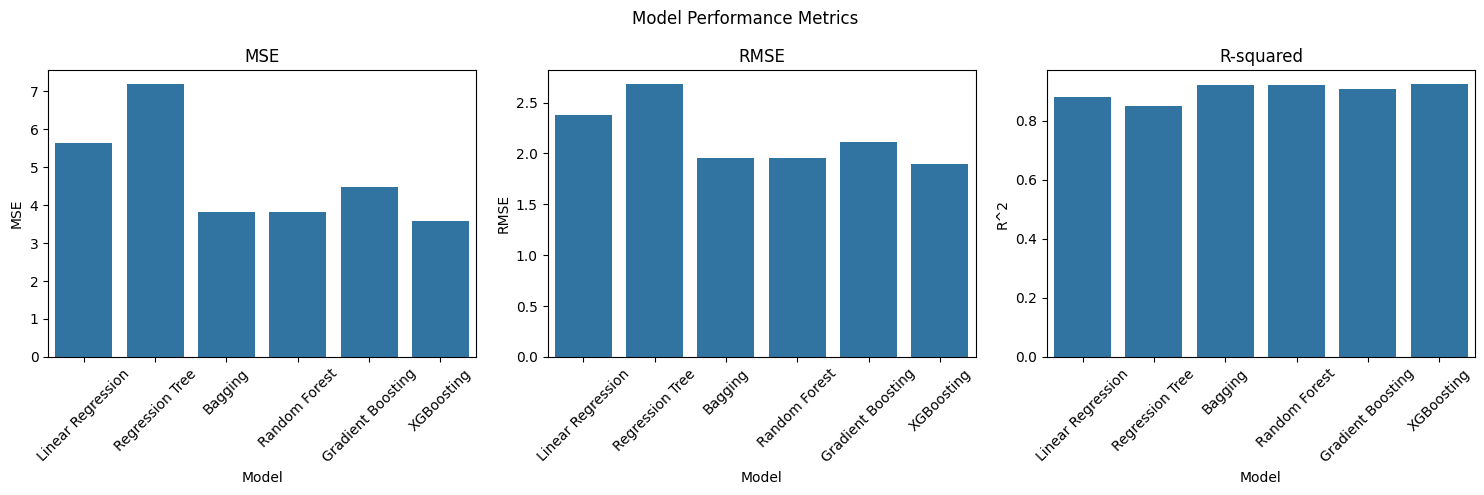

In [ ]:
# MSE, RMSE, and R^2 of the six models, printing into dataframe
MSE = []
RMSE = []
R2 = []
models = [lin_reg, reg_tree, bag_reg, rf_reg, gb_reg, xgb_reg]
titles = ['Linear Regression', 'Regression Tree', 'Bagging', 'Random Forest', 'Gradient Boosting', 'XGBoosting']
for i, model in enumerate(models):
  y_pred = model.predict(X_test)
  MSE.append(mean_squared_error(y_test, y_pred))
  RMSE.append(np.sqrt(MSE[i]))
  R2.append(r2_score(y_test, y_pred))

df_output = pd.DataFrame({'Model': titles, 'MSE': MSE, 'RMSE': RMSE, 'R^2': R2})
print(f'{df_output}\n')

# Bar graph visualizations using seaborn
df_output = pd.DataFrame({'Model': titles, 'MSE': MSE, 'RMSE': RMSE, 'R^2': R2})

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Model Performance Metrics')

sns.barplot(x='Model', y='MSE', data=df_output, ax=axs[0])
axs[0].set_title('MSE')
axs[0].tick_params(axis='x', rotation=45)

sns.barplot(x='Model', y='RMSE', data=df_output, ax=axs[1])
axs[1].set_title('RMSE')
axs[1].tick_params(axis='x', rotation=45)

sns.barplot(x='Model', y='R^2', data=df_output, ax=axs[2])
axs[2].set_title('R-squared')
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

What do these values mean? what is MSE? RMSE? R^2? EDIT!!

###Visualizing the Models

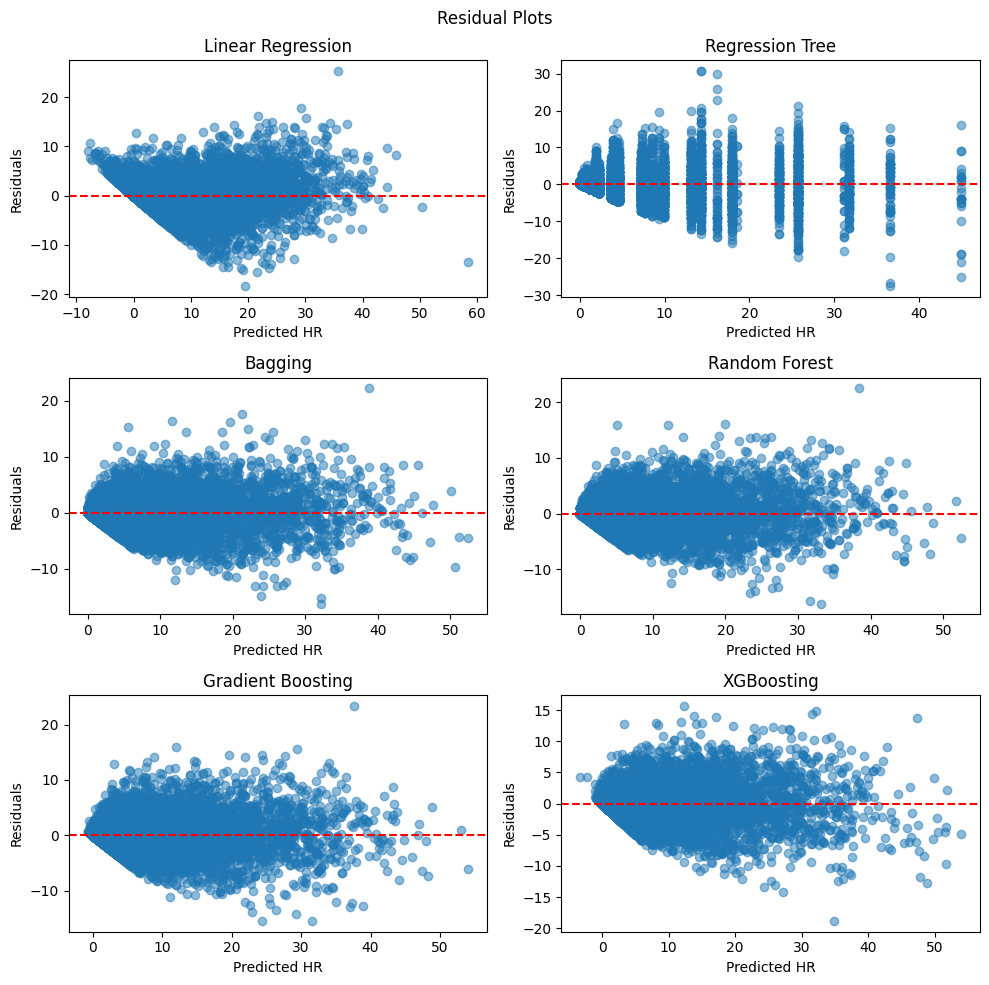

In [ ]:
# First, plotting residuals
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle('Residual Plots')

for i, ax in enumerate(axs.flat):
    model = models[i]
    title = titles[i]

    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    ax.scatter(y_pred, residuals, alpha=0.5)
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel('Predicted HR')
    ax.set_ylabel('Residuals')

plt.tight_layout()
plt.show()

Why do this? What are residuals? What can we look for in the graphs? density visualizations? EDIT!!

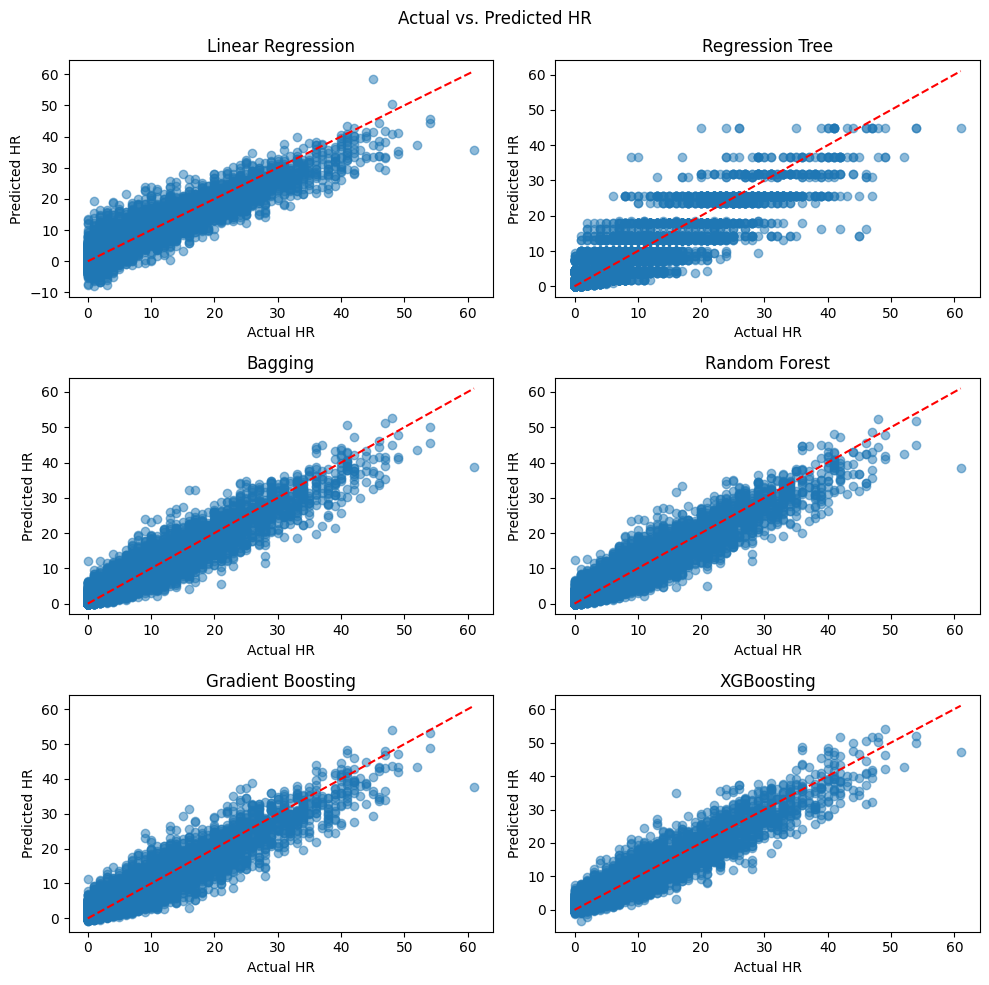

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle('Actual vs. Predicted HR')

for i, ax in enumerate(axs.flat):
    model = models[i]
    title = titles[i]

    y_pred = model.predict(X_test)

    ax.scatter(y_test, y_pred, alpha=0.5)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel('Actual HR')
    ax.set_ylabel('Predicted HR')

plt.tight_layout()
plt.show()

Why do this?? can we make it density based for better readibility? What would overfit look like?

##Predictions by Previous Season

In [ ]:
df2 = df.copy()

# Keeping yearID this time, it's what we're isolating
df2.drop(columns=['stint', 'teamID', 'lgID', 'G_batting', 'G_old'], inplace=True)
df2.head()

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,aardsda01,2004,11,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,aardsda01,2006,45,2,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0
2,aardsda01,2007,25,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,aardsda01,2008,47,1,0,0,0,0,0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0
4,aardsda01,2009,73,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_year = df2[df2['AB'] != 0]
print(df_year['AB'].value_counts())

df_year.head(10)

AB
1      4289
2      3016
3      2527
4      2266
5      1694
       ... 
688       1
716       1
701       1
704       1
705       1
Name: count, Length: 698, dtype: int64


,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
1,aardsda01,2006,45,2,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0
3,aardsda01,2008,47,1,0,0,0,0,0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0
8,aardsda01,2015,33,1,0,0,0,0,0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0
9,aaronha01,1954,122,468,58,131,27,6,13,69.0,2.0,2.0,28,39.0,NaN,3.0,6.0,4.0,13.0
10,aaronha01,1955,153,602,105,189,37,9,27,106.0,3.0,1.0,49,61.0,5.0,3.0,7.0,4.0,20.0
11,aaronha01,1956,153,609,106,200,34,14,26,92.0,2.0,4.0,37,54.0,6.0,2.0,5.0,7.0,21.0
12,aaronha01,1957,151,615,118,198,27,6,44,132.0,1.0,1.0,57,58.0,15.0,0.0,0.0,3.0,13.0
13,aaronha01,1958,153,601,109,196,34,4,30,95.0,4.0,1.0,59,49.0,16.0,1.0,0.0,3.0,21.0
14,aaronha01,1959,154,629,116,223,46,7,39,123.0,8.0,0.0,51,54.0,17.0,4.0,0.0,9.0,19.0
15,aaronha01,1960,153,590,102,172,20,11,40,126.0,16.0,7.0,60,63.0,13.0,2.0,0.0,12.0,8.0


In [ ]:
df_drop['yearID'] = df_year['yearID']
df_drop['playerID'] = df_year['playerID']
df_drop['HR'] = df_year['HR']
df_drop.head(10).round(2)

,AB,R,H,2B,3B,RBI,BB,SO,IBB,SH,...,GIDP,H/AB,H/G,SO/AB,RBI-R,IBB+HBP,SB/AB,yearID,playerID,HR
1,2,0,0,0,0,0.0,0,0.0,0.00,1.0,...,0.0,0.00,0.00,0.00,0.0,0.00,0.00,2006,aardsda01,0
3,1,0,0,0,0,0.0,0,1.0,0.00,0.0,...,0.0,0.00,0.00,1.00,0.0,0.00,0.00,2008,aardsda01,0
8,1,0,0,0,0,0.0,0,1.0,0.00,0.0,...,0.0,0.00,0.00,1.00,0.0,0.00,0.00,2015,aardsda01,0
9,468,58,131,27,6,69.0,28,39.0,2.96,6.0,...,13.0,0.28,1.07,0.08,11.0,5.96,0.00,1954,aaronha01,13
10,602,105,189,37,9,106.0,49,61.0,5.00,7.0,...,20.0,0.31,1.24,0.10,1.0,8.00,0.00,1955,aaronha01,27
11,609,106,200,34,14,92.0,37,54.0,6.00,5.0,...,21.0,0.33,1.31,0.09,-14.0,8.00,0.00,1956,aaronha01,26
12,615,118,198,27,6,132.0,57,58.0,15.00,0.0,...,13.0,0.32,1.31,0.09,14.0,15.00,0.00,1957,aaronha01,44
13,601,109,196,34,4,95.0,59,49.0,16.00,0.0,...,21.0,0.33,1.28,0.08,-14.0,17.00,0.01,1958,aaronha01,30
14,629,116,223,46,7,123.0,51,54.0,17.00,0.0,...,19.0,0.35,1.45,0.09,7.0,21.00,0.01,1959,aaronha01,39
15,590,102,172,20,11,126.0,60,63.0,13.00,0.0,...,8.0,0.29,1.12,0.11,24.0,15.00,0.03,1960,aaronha01,40


As we can see from the previous df_year.head() and this df_drop.head(), the rows are lined up correctly, so now we have yearID in the data!

In [ ]:
print(df_drop['yearID'].value_counts())
df_drop.shape

yearID
2021    1127
2000    1065
2018    1060
2019    1059
2001    1044
        ... 
1876     124
1874     123
1871     115
1877      98
1878      80
Name: count, Length: 153, dtype: int64


(93812, 21)

Fortunately, the data is already sorted by playerID then yearID

In [ ]:
# Creating shifted features
lagged_features = df_drop.groupby('playerID').shift(1)

# Renaming features
lagged_features.columns = [f'{col}_prev_year' for col in lagged_features.columns]

# Combining df's
df_lagged = pd.concat([df_drop, lagged_features], axis=1)

print(df_lagged.shape)
df_lagged.head()

(93812, 41)


,AB,R,H,2B,3B,RBI,BB,SO,IBB,SH,...,SF_prev_year,GIDP_prev_year,H/AB_prev_year,H/G_prev_year,SO/AB_prev_year,RBI-R_prev_year,IBB+HBP_prev_year,SB/AB_prev_year,yearID_prev_year,HR_prev_year
1,2,0,0,0,0,0.0,0,0.0,0.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,0,0,0,0.0,0,1.0,0.000000,0.0,...,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,2006.0,0.0
8,1,0,0,0,0,0.0,0,1.0,0.000000,0.0,...,0.0,0.0,0.000000,0.00000,1.000000,0.0,0.000000,0.000000,2008.0,0.0
9,468,58,131,27,6,69.0,28,39.0,2.961088,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,602,105,189,37,9,106.0,49,61.0,5.000000,7.0,...,4.0,13.0,0.279915,1.07377,0.083333,11.0,5.961088,0.004274,1954.0,13.0


Notably, some players have missed seasons during their career due to injuries or other events. We still want this data, and we'll simply predict off of previous season played, whether it was the actual previous year or not.

Also, notice the 18,111 NaN's in each _prev_year feature, these represent rookie seasons, where no previous year's data exists

Now we drop everything we no longer need, since we want to predict off of lagged data only

In [ ]:
# First, initial years data
df_lagged.drop(columns=['AB', 'R', 'H', '2B', '3B', 'RBI', 'BB', 'SO','IBB',
                        'SH', 'SF', 'GIDP', 'H/AB', 'H/G', 'SO/AB','RBI-R',
                        'IBB+HBP','SB/AB'], inplace=True)
df_lagged.head()

,yearID,playerID,HR,AB_prev_year,R_prev_year,H_prev_year,2B_prev_year,3B_prev_year,RBI_prev_year,BB_prev_year,...,SF_prev_year,GIDP_prev_year,H/AB_prev_year,H/G_prev_year,SO/AB_prev_year,RBI-R_prev_year,IBB+HBP_prev_year,SB/AB_prev_year,yearID_prev_year,HR_prev_year
1,2006,aardsda01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008,aardsda01,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,2006.0,0.0
8,2015,aardsda01,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.00000,1.000000,0.0,0.000000,0.000000,2008.0,0.0
9,1954,aaronha01,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1955,aaronha01,27,468.0,58.0,131.0,27.0,6.0,69.0,28.0,...,4.0,13.0,0.279915,1.07377,0.083333,11.0,5.961088,0.004274,1954.0,13.0


In [ ]:
# Now, rookie years, so drop every row with no previous yearID data
df_lagged.dropna(subset=['yearID_prev_year'], inplace=True)
print(df_lagged.isnull().sum().sum())
df_lagged.head(10)

0


,yearID,playerID,HR,AB_prev_year,R_prev_year,H_prev_year,2B_prev_year,3B_prev_year,RBI_prev_year,BB_prev_year,...,SF_prev_year,GIDP_prev_year,H/AB_prev_year,H/G_prev_year,SO/AB_prev_year,RBI-R_prev_year,IBB+HBP_prev_year,SB/AB_prev_year,yearID_prev_year,HR_prev_year
3,2008,aardsda01,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2006.0,0.0
8,2015,aardsda01,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,2008.0,0.0
10,1955,aaronha01,27,468.0,58.0,131.0,27.0,6.0,69.0,28.0,...,4.0,13.0,0.279915,1.073770,0.083333,11.0,5.961088,0.004274,1954.0,13.0
11,1956,aaronha01,26,602.0,105.0,189.0,37.0,9.0,106.0,49.0,...,4.0,20.0,0.313953,1.235294,0.101329,1.0,8.000000,0.004983,1955.0,27.0
12,1957,aaronha01,44,609.0,106.0,200.0,34.0,14.0,92.0,37.0,...,7.0,21.0,0.328407,1.307190,0.088670,-14.0,8.000000,0.003284,1956.0,26.0
13,1958,aaronha01,30,615.0,118.0,198.0,27.0,6.0,132.0,57.0,...,3.0,13.0,0.321951,1.311258,0.094309,14.0,15.000000,0.001626,1957.0,44.0
14,1959,aaronha01,39,601.0,109.0,196.0,34.0,4.0,95.0,59.0,...,3.0,21.0,0.326123,1.281046,0.081531,-14.0,17.000000,0.006656,1958.0,30.0
15,1960,aaronha01,40,629.0,116.0,223.0,46.0,7.0,123.0,51.0,...,9.0,19.0,0.354531,1.448052,0.085851,7.0,21.000000,0.012719,1959.0,39.0
16,1961,aaronha01,34,590.0,102.0,172.0,20.0,11.0,126.0,60.0,...,12.0,8.0,0.291525,1.124183,0.106780,24.0,15.000000,0.027119,1960.0,40.0
17,1962,aaronha01,45,603.0,115.0,197.0,39.0,10.0,120.0,56.0,...,9.0,16.0,0.326700,1.270968,0.106136,5.0,22.000000,0.034826,1961.0,34.0


This is awesome, no missing values, and cross referencing this preview of the data we can see the yearID's look correctly shifted and all is well (probably).

## Models Part 2

I'm repeating much of the same code here, so a lot of variables are reassigned but we don't mind at this point. Also dropping playerID and yearID now that we want to train our models, if we want to examine the data further later, we could reintegrate those features.

In [ ]:
# Classic

X = df_lagged.drop(columns=['HR', 'playerID', 'yearID'])
y = df_lagged['HR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=356)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60560, 20)
(15141, 20)
(60560,)
(15141,)


My top models before were Bagging and XGBoosting, lets try those two.

In [ ]:
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)
MSE_lr = mean_squared_error(y_test, y_pred_lr)
RMSE_lr = np.sqrt(MSE_lr)
R2_lr = r2_score(y_test, y_pred_lr)

# Regression Tree
reg_tree = DecisionTreeRegressor(max_depth=5)
reg_tree.fit(X_train, y_train)
y_pred_rt = reg_tree.predict(X_test)
MSE_rt = mean_squared_error(y_test, y_pred_rt)
RMSE_rt = np.sqrt(MSE_rt)
R2_rt = r2_score(y_test, y_pred_rt)

# Bagging
bag_reg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, bootstrap = True, oob_score = False)
bag_reg.fit(X_train, y_train)
y_pred_b = bag_reg.predict(X_test)
MSE_b = mean_squared_error(y_test, y_pred_b)
RMSE_b = np.sqrt(MSE_b)
R2_b = r2_score(y_test, y_pred_b)

# Random Forest (Basically Bagging)
rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)
MSE_rf = mean_squared_error(y_test, y_pred_rf)
RMSE_rf = np.sqrt(MSE_rf)
R2_rf = r2_score(y_test, y_pred_rf)

# Gradient Boosting
gb_reg = GradientBoostingRegressor(n_estimators=100)
gb_reg.fit(X_train, y_train)
y_pred_gb = gb_reg.predict(X_test)
MSE_gb = mean_squared_error(y_test, y_pred_gb)
RMSE_gb = np.sqrt(MSE_gb)
R2_gb = r2_score(y_test, y_pred_gb)

# XGBoosting
xgb_reg = xgb.XGBRegressor(n_estimators=100)
xgb_reg.fit(X_train, y_train)
y_pred_xgb = xgb_reg.predict(X_test)
MSE_xgb = mean_squared_error(y_test, y_pred_xgb)
RMSE_xgb = np.sqrt(MSE_xgb)
R2_xgb = r2_score(y_test, y_pred_xgb)

               Model        MSE      RMSE       R^2
0  Linear Regression  22.255131  4.717534  0.594182
1    Regression Tree  22.791565  4.774051  0.584400
2            Bagging  22.211880  4.712948  0.594970
3      Random Forest  22.317416  4.724131  0.593046
4  Gradient Boosting  21.431541  4.629421  0.609200
5         XGBoosting  22.351336  4.727720  0.592427



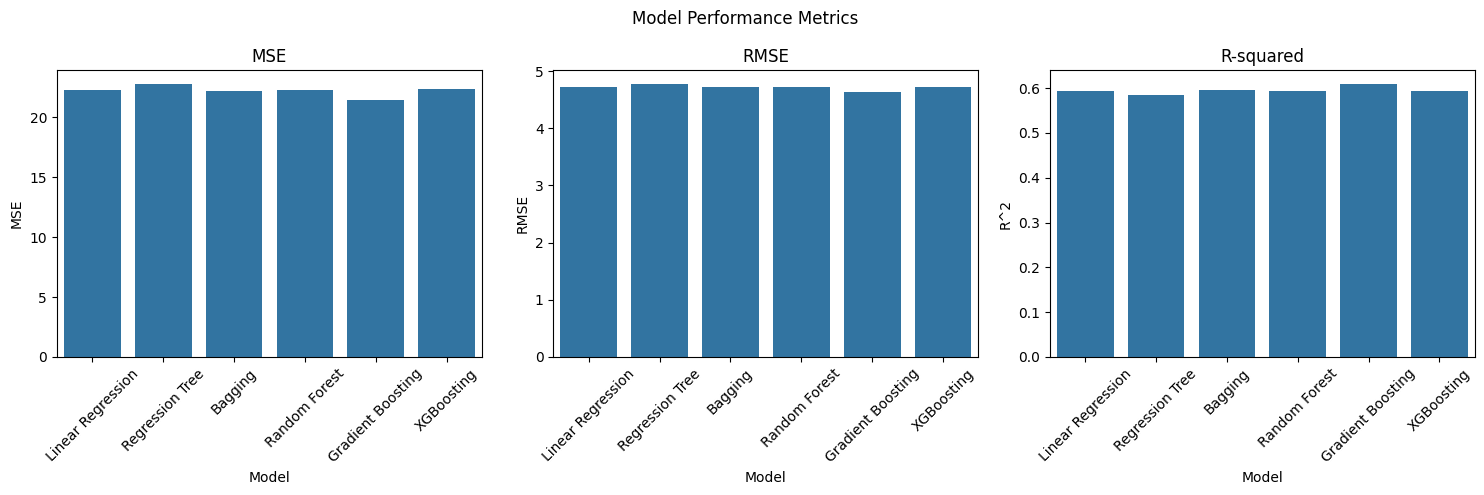

In [ ]:
# MSE, RMSE, and R^2 of the six models, printing into dataframe
MSE = []
RMSE = []
R2 = []
models = [lin_reg, reg_tree, bag_reg, rf_reg, gb_reg, xgb_reg]
titles = ['Linear Regression', 'Regression Tree', 'Bagging', 'Random Forest', 'Gradient Boosting', 'XGBoosting']
for i, model in enumerate(models):
  y_pred = model.predict(X_test)
  MSE.append(mean_squared_error(y_test, y_pred))
  RMSE.append(np.sqrt(MSE[i]))
  R2.append(r2_score(y_test, y_pred))

df_output = pd.DataFrame({'Model': titles, 'MSE': MSE, 'RMSE': RMSE, 'R^2': R2})
print(f'{df_output}\n')

# Bar graph visualizations using seaborn
df_output = pd.DataFrame({'Model': titles, 'MSE': MSE, 'RMSE': RMSE, 'R^2': R2})

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Model Performance Metrics')

sns.barplot(x='Model', y='MSE', data=df_output, ax=axs[0])
axs[0].set_title('MSE')
axs[0].tick_params(axis='x', rotation=45)

sns.barplot(x='Model', y='RMSE', data=df_output, ax=axs[1])
axs[1].set_title('RMSE')
axs[1].tick_params(axis='x', rotation=45)

sns.barplot(x='Model', y='R^2', data=df_output, ax=axs[2])
axs[2].set_title('R-squared')
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

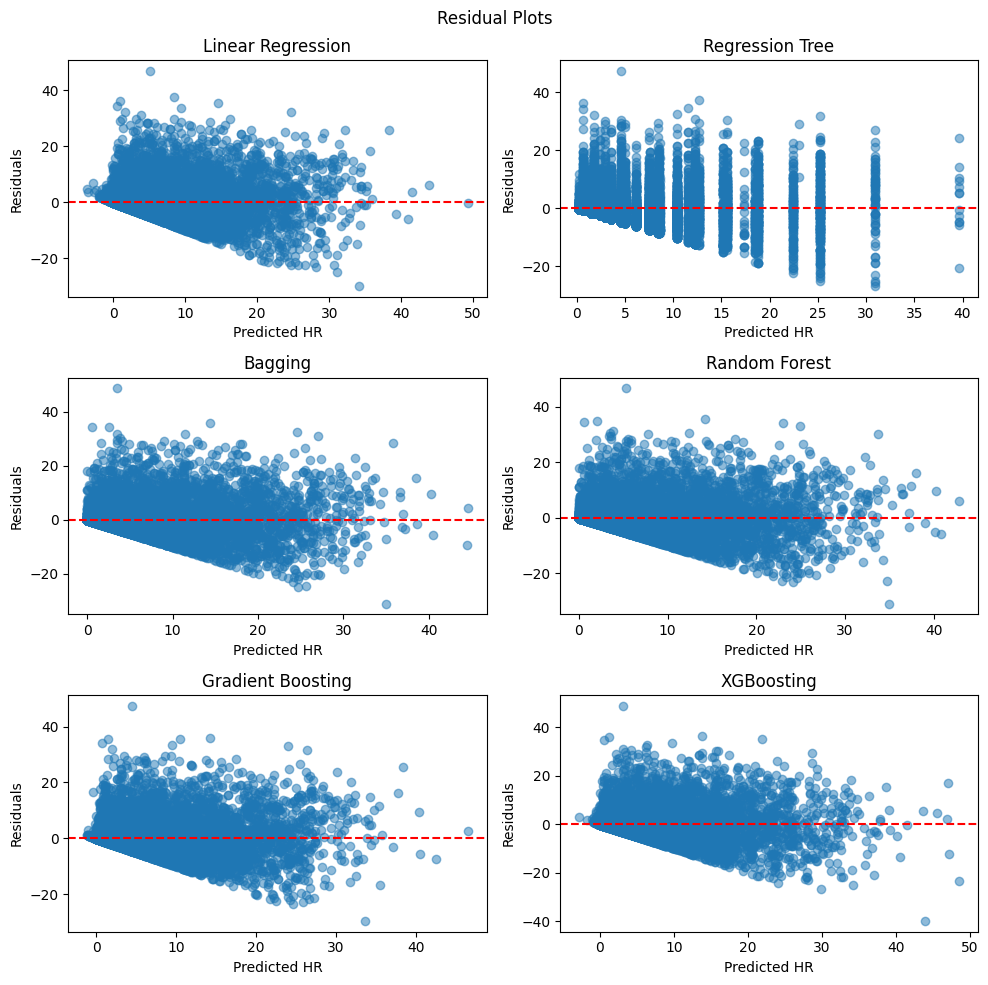

In [ ]:
# First, plotting residuals
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle('Residual Plots')

for i, ax in enumerate(axs.flat):
    model = models[i]
    title = titles[i]

    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    ax.scatter(y_pred, residuals, alpha=0.5)
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel('Predicted HR')
    ax.set_ylabel('Residuals')

plt.tight_layout()
plt.show()

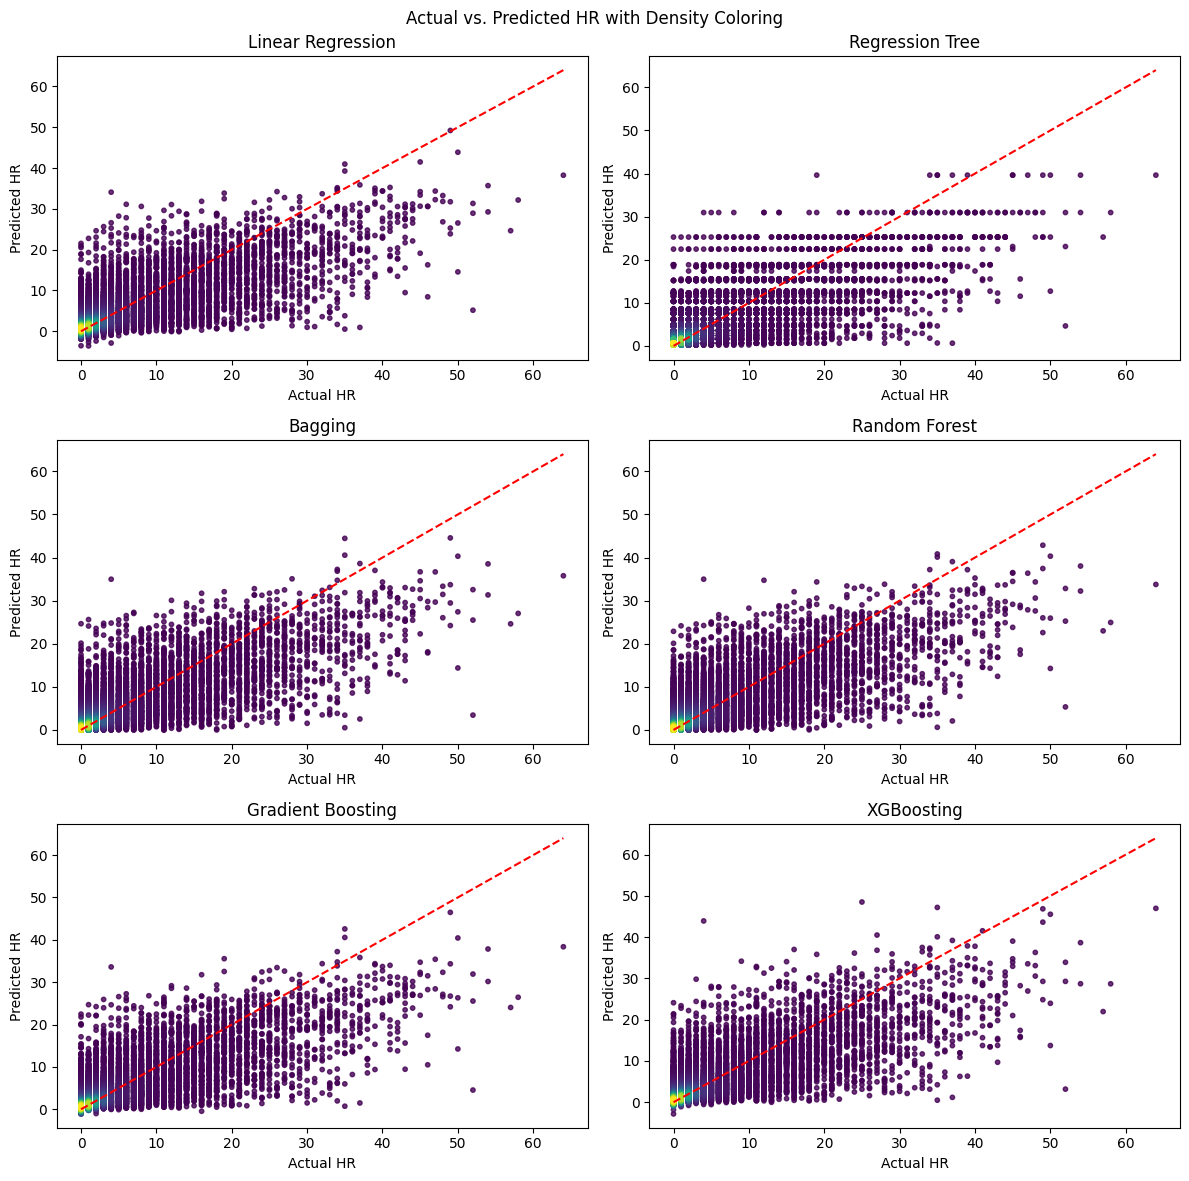

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle('Actual vs. Predicted HR with Density Coloring')

for i, ax in enumerate(axs.flat):
    model = models[i]
    title = titles[i]

    y_pred = model.predict(X_test)

    # Calculating point density
    xy = np.vstack([y_test, y_pred])
    z = gaussian_kde(xy)(xy)

    # Dense points get placed last
    idx = z.argsort()
    x, y, z = y_test.iloc[idx], y_pred[idx], z[idx]

    # Making scatter plot with density
    scatter = ax.scatter(x, y, c=z, cmap='viridis', s=10, alpha=0.8)

    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel('Actual HR')
    ax.set_ylabel('Predicted HR')

plt.tight_layout()
plt.show()

##How could I improve my model?

The most obvious improvement would be to incorportate not only a given players previous seasons stats, but instead their lifetime stats. This would account for anomaly seasons, and could be able to account for player regression over time.

Other potential flaws: dropping years where AB=0?